# Neighborhood Recommender

The following model has the objective of recommending a top 10 list of neighborhoods where to live in Mexico City.

In order to this, the model is based on finding neighborhoods that have the type of venues that the person (user) like the most.

The model considers that the user will provide the rent amount willing to pay, what or where are the offices to be relocated, and also the type of venues he'd like to have around ranked.

## 1 Import Geolocation and Rent data

Neighborhoods' geolocation data was downloaded from https://datos.cdmx.gob.mx/explore/dataset/coloniascdmx/export/ 

Average rent cost per neighborhood was gathered manually from https://propiedades.com/valores/19-de-mayo-df/departamentos-renta considering as search parameters: Rent, Apartment, DF / CDMX, Neighborhood

All of this information collected was consolidated in the MX_Neighborhoods_Geo_Rent.csv file

In [141]:
# Read the file and create a pandas df with it

import pandas as pd
df_cdmx = pd.read_csv('MX_Neighborhoods_Geo_Rent.csv')
df_cdmx.head()

,Municipality,Neighborhood,Neighborhood_Municipality,Latitude,Longitude,Rent
0,BENITO JUAREZ,ACACIAS,"ACACIAS, BENITO JUAREZ",19.364106,-99.174065,18822
1,BENITO JUAREZ,ACTIPAN,"ACTIPAN, BENITO JUAREZ",19.369882,-99.178167,17707
2,BENITO JUAREZ,ALAMOS I,"ALAMOS I, BENITO JUAREZ",19.400430,-99.140929,11413
3,BENITO JUAREZ,ALAMOS II,"ALAMOS II, BENITO JUAREZ",19.394901,-99.142231,11413
4,BENITO JUAREZ,ALBERT,"ALBERT, BENITO JUAREZ",19.370574,-99.139390,11258


In [143]:
# Install required components to handle the data and analyse it

import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

Let's start analysing the data by creating an histogram to evaluate how rent cost is distributed

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f745cb6c9b0>]],
      dtype=object)

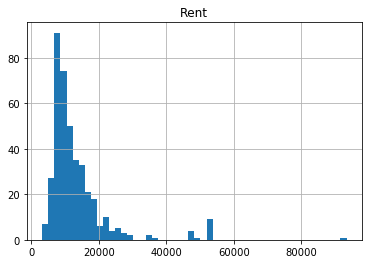

In [70]:
# Histogram to analyse rent cost distribution

df_cdmx.hist(column='Rent', bins=50)

Let's calculate the average rent cost by municipality to start evaluating which of them are in the user's budget range

In [85]:
# Create dataframe to plot the average rent by municipality

df_cdmx_rent = df_cdmx.groupby('Municipality').mean().reset_index()
df_cdmx_rent.drop(columns=['Latitude', 'Longitude'], inplace=True)
df_cdmx_rent.sort_values(by=['Rent'], ascending=False, inplace=True)
df_cdmx_rent.set_index('Municipality', inplace=True)
df_cdmx_rent

,Rent
Municipality,
MIGUEL HIDALGO,21289.988095
BENITO JUAREZ,14903.111111
CUAUHTEMOC,11895.841270
COYOACAN,10953.774648
IZTACALCO,7182.519231


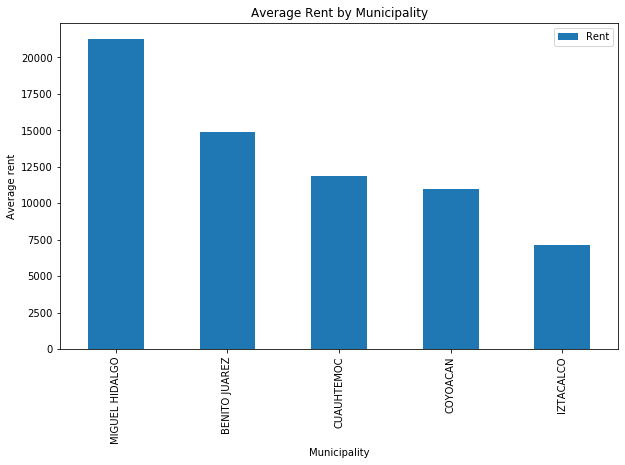

In [86]:
# step 2: plot data

df_cdmx_rent.plot(kind='bar', figsize=(10, 6), )

plt.xlabel('Municipality') # add to x-label to the plot
plt.ylabel('Average rent') # add y-label to the plot
plt.title('Average Rent by Municipality') # add title to the plot

plt.show()

According to the bar graph, the most expensive Municipality is Mighel Hidalgo which has an average rent a bit above the 20,000 mexican pesos. In contrast, Iztacalco Municipality is the cheapest with an average rent around 7,500 mexican pesos

## 2 Get user's data

The data required as an input from the user is the following:

a) Office where the user will work in Mexico City - We are using "IBM, Mexico city" in this example

b) Top 5 venue categories preferences that the user wants around her home in Mexico City - Type of venues should be provided ranked, we are using for this example:

    1 - Coffee Shop
    2 - Japanese Restaurant
    3 - Gym / Fitness Center
    4 - Mexican Restaurant
    5 - Park

c) Rent cost willing to pay in Mexico City in Mexican Pesos - $15,000 Mexican pesos for this example

In [4]:
# Install Mominatim to get the geolocation information of User's office in Mexico City

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.22.0               |     pyh9f0ad1d_0          63 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          97 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-1.22.0-pyh9f0ad1d_0



geopy-1.22.0         | 63 KB     | ##################################### | 100% 
geographiclib-1.50   | 34 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: 

In [6]:
# Get Folium to create the map

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

print('Libraries imported.')

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    altair-4.1.0               |             py_1         614 KB  conda-forge
    branca-0.4.1               |             py_0          26 KB  conda-forge
    brotlipy-0.7.0             |py36h8c4c3a4_1000         346 KB  conda-forge
    chardet-3.0.4              |py36h9f0ad1d_1006         188 KB  conda-forge
    cryptography-2.9.2         |   py36h45558ae_0         613 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    pandas-1.0.5               |   py36h830a2c2_0        10.1 MB  conda-forge
    pysocks-1.7.1              |   py36h9f0ad1d_1          27 KB  conda-

In [144]:
# IBM, Mexico City it's been used in this example as the work place were the user will be working in Mexico City

user_office = 'IBM, Mexico city'

geolocator = Nominatim(user_agent="office_explorer")
office_location = geolocator.geocode(user_office)
office_latitude = location.latitude
office_longitude = location.longitude
print('The geograpical coordinate of users office are {}, {}.'.format(office_latitude, office_longitude))

The geograpical coordinate of users office are 19.37187335, -99.26118151812653.


In [145]:
# Create dataframe with office's lat and log

df_office = pd.DataFrame([[office_latitude, office_longitude]],columns=['Latitude','Longitude'])
df_office

,Latitude,Longitude
0,19.371873,-99.261182


In [149]:
# Get user's office latitude and longitude as variables to be used in the marker

x = df_office['Latitude']
of_lat = x.values[0]
y = df_office['Longitude']
of_lon = y.values[0]
print(of_lat, ", ", of_lon)

19.37187335 ,  -99.26118151812653


In [146]:
# Generate Mexico City's lat and lon to create a map in the next step

address = 'Mexico City'

geolocator = Nominatim(user_agent="mx_explorer")
cdmx_location = geolocator.geocode(address)
cdmx_latitude = location.latitude
cdmx_longitude = location.longitude
print('The geograpical coordinate of Mexico City are {}, {}.'.format(cdmx_latitude, cdmx_longitude))

The geograpical coordinate of Mexico City are 19.37187335, -99.26118151812653.


The following map shows all neighborhoods belonging to the five municipalities selected, as well as the future user's working place.

The aim of this project is to find the best ten neighborhoods from all of these neighborhoods shown on the map

In [148]:
# create map of Mexico city showing the office location and all neighborhoods

cdmx = folium.Map(location=[cdmx_latitude, cdmx_longitude], zoom_start=11)
 
# Get user's office latitude and longitude
    
folium.Marker(location=[of_lat, of_lon], popup='Office', icon=folium.Icon(color='red', icon='info-sign')).add_to(cdmx)

# add markers to map
for lat, lng, borough, neighborhood, average_rent in zip(df_cdmx['Latitude'], df_cdmx['Longitude'], df_cdmx['Municipality'], df_cdmx['Neighborhood'], df_cdmx['Rent']):
    label = 'Avg Rent $ {}, Mun {}, Nbh {}'.format(distance, average_rent, borough, neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='Purple',
        fill=True,
        fill_color='#9900FF',
        fill_opacity=0.7,
        parse_html=False).add_to(cdmx) 
    
cdmx

In the next cell we're going to create a pandas dataframe containing the type of venues that the user like the most.

Along with the venue category a rating is added, this rating will be used to weight all venues to be gathered from Foursquare in the following steps.

In [11]:
# Get user's data

user_data = [ ('Coffee Shop', 10) ,
             ('Japanese Restaurant', 8) ,
             ('Gym / Fitness Center', 6) ,
             ('Mexican Restaurant', 4) ,
             ('Park', 2)]

# Create DataFrame 
df_user = pd.DataFrame(user_data, columns = ['Venue Category', 'Rating'])   
df_user

,Venue Category,Rating
0,Coffee Shop,10
1,Japanese Restaurant,8
2,Gym / Fitness Center,6
3,Mexican Restaurant,4
4,Park,2


In [151]:
# Get rent amount that user's willing to pay

user_rent = 15000
user_rent

15000

In [152]:
# Calculate a rent range considering a 20% of variation

a = user_rent * 1.2
b = user_rent - (user_rent * 0.2)
print(b, " to ", a)

12000.0  to  18000.0


In [155]:
# Create a new dataframe to filter data based on the rent range defined

df_cdmx_filtered = df_cdmx.copy()
df_cdmx_filtered = df_cdmx_filtered.query("Rent > @b & Rent < @a") #Filter
df_cdmx_filtered = df_cdmx_filtered.reset_index(drop=True) #Reset index
print(df_cdmx_filtered.shape)
df_cdmx_filtered.head(20)

(100, 6)


,Municipality,Neighborhood,Neighborhood_Municipality,Latitude,Longitude,Rent
0,BENITO JUAREZ,ACTIPAN,"ACTIPAN, BENITO JUAREZ",19.369882,-99.178167,17707
1,BENITO JUAREZ,CIUDAD DE LOS DEPORTES,"CIUDAD DE LOS DEPORTES, BENITO JUAREZ",19.383390,-99.180064,15804
2,BENITO JUAREZ,EXTREMADURA INSURGENTES,"EXTREMADURA INSURGENTES, BENITO JUAREZ",19.377035,-99.179869,17609
3,BENITO JUAREZ,GENERAL PEDRO MARIA ANAYA,"GENERAL PEDRO MARIA ANAYA, BENITO JUAREZ",19.360482,-99.158773,16375
4,BENITO JUAREZ,INDEPENDENCIA,"INDEPENDENCIA, BENITO JUAREZ",19.379773,-99.148095,12409
5,BENITO JUAREZ,INSURGENTES SAN BORJA,"INSURGENTES SAN BORJA, BENITO JUAREZ",19.383526,-99.174046,17204
6,BENITO JUAREZ,LETRAN VALLE,"LETRAN VALLE, BENITO JUAREZ",19.376132,-99.155067,16625
7,BENITO JUAREZ,MERCED GOMEZ,"MERCED GOMEZ, BENITO JUAREZ",19.365642,-99.189928,15802
8,BENITO JUAREZ,MIRAVALLE,"MIRAVALLE, BENITO JUAREZ",19.361304,-99.141089,13280
9,BENITO JUAREZ,MIXCOAC,"MIXCOAC, BENITO JUAREZ",19.372884,-99.190003,14264


## 3 Get venues' data per neighborhood

For this part, the Foursquare api, endpoint explore is used

In [16]:
# Install components required to handle JSON files

import json # library to handle JSON files
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

In [17]:
# Save variables required to access Foursquare: CLIENT_ID, CLIENT_SECRET and VERSION
# @hidden_cell

CLIENT_ID = 'ZRDR4VMLR3U14PHLUME3QC1CG5L4XXUBSKE4COCHEK4VBWJX' # your Foursquare ID
CLIENT_SECRET = 'KCXILXTJ0HCJXRJHO0TJZIF3ZCANQEBNSWTC3FLFEK1XFKF4' # your Foursquare Secret
VERSION = '20200601' # Foursquare API version

# print('Your credentails:')
# print('CLIENT_ID: ' + CLIENT_ID)
# print('CLIENT_SECRET:' + CLIENT_SECRET)

In [156]:
# Test the connection to Foursquare passing the first neighborhood

df_cdmx_filtered.loc[0, 'Neighborhood']

'ACTIPAN'

In [19]:
# Storing neighborhood's Lat and Long

neighborhood_latitude = df_cdmx_filtered.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = df_cdmx_filtered.loc[0, 'Longitude'] # neighborhood longitude value
neighborhood_name = df_cdmx_filtered.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of ACTIPAN are 19.36988192, -99.17816705.


In [20]:
# Create the URL to access Foursquare

LIMIT = 100 # limit of number of venues returned by Foursquare API

radius = 500 # redius around the neighborhood to explore

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
# url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=ZRDR4VMLR3U14PHLUME3QC1CG5L4XXUBSKE4COCHEK4VBWJX&client_secret=KCXILXTJ0HCJXRJHO0TJZIF3ZCANQEBNSWTC3FLFEK1XFKF4&v=20200601&ll=19.36988192,-99.17816705&radius=500&limit=100'

In [21]:
# Get venues around test neighborhood - explore endpoint

results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5eecfd68bae9a2001b58e7f0'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Actipan',
  'headerFullLocation': 'Actipan, Mexico City',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 113,
  'suggestedBounds': {'ne': {'lat': 19.374381924500007,
    'lng': -99.17340595594162},
   'sw': {'lat': 19.365381915499995, 'lng': -99.18292814405838}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '598ce75bf0b49078f26eaf74',
       'name': 'Puro Amor',
       'location': {'lat': 19.369499,
        'lng': -99.176386,
        'labeledLatLngs': [{'label': 'display',
          'lat': 19.369499,
          'lng': -99.176386}],
        'distance': 

In [23]:
# Function that extracts the category of the venue

def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [24]:
# Create dataframe with json data

venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues = nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  """


,name,categories,lat,lng
0,Puro Amor,Vegetarian / Vegan Restaurant,19.369499,-99.176386
1,Build-A-Bear Workshop,Toy / Game Store,19.371380,-99.179353
2,Cambalache,Argentinian Restaurant,19.371139,-99.179760
3,Johnny Rockets,Burger Joint,19.371168,-99.178445
4,Tacos Miguel De Pechuga,Taco Place,19.370888,-99.176567


In [25]:
# Function to get near venues for all neighborhoods

## Rerun this cell if error!!

def getNearbyVenues(names, latitudes, longitudes, radius=500):
        
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [26]:
# Create dataframe with venues information

cdmx_venues = getNearbyVenues(names=df_cdmx_filtered['Neighborhood'],
                                   latitudes=df_cdmx_filtered['Latitude'],
                                   longitudes=df_cdmx_filtered['Longitude']
                                  )

ACTIPAN
CIUDAD DE LOS DEPORTES
EXTREMADURA INSURGENTES
GENERAL PEDRO MARIA ANAYA
INDEPENDENCIA
INSURGENTES SAN BORJA
LETRAN VALLE
MERCED GOMEZ
MIRAVALLE
MIXCOAC
NARVARTE I
NARVARTE II
NARVARTE III
NARVARTE IV
NARVARTE V
NARVARTE VI
NOCHE BUENA
NONOALCO
OCHO DE AGOSTO
PIEDAD NARVARTE
PORTALES I
PORTALES II
PORTALES III
PORTALES IV
RESIDENCIAL EMPERADORES
SAN JUAN
SAN PEDRO DE LOS  PINOS
VERTIZ NARVARTE
ALTILLO COND ALTILLO UNIVERSIDAD
ATLANTIDA
BOSQUES DE TETLAMEYA
CAMPESTRE COYOACAN FRACC
CANTIL DEL PEDREGAL
CIUDAD JARDIN
COPILCO EL BAJO
COPILCO UNIVERSIDAD
COUNTRY CLUB
CUADRANTE DE SAN FRANCISCO
DE LA CANDELARIA PBLO
DEL CARMEN
DEL NIÑO JESUS BARR
EL CARACOL
EL PARQUE DE COYOACAN FRACC
EL RELOJ
EL ROSEDAL I
EL ROSEDAL II
EX EJIDO DE CHURUBUSCO
EX HACIENDA COAPA
HERMOSILLO
INSURGENTES CUICUILCO
INTEGRACION LATINOAMERICANA U HAB
JOYAS DEL PEDREGAL FRACC
LA CANTERA U HAB
LA CONCEPCION BARR
LOS REYES PBLO
LOS SAUCES FRACC
OLIMPICA
OXTOPULCO UNIVERSIDAD
PARQUE SAN ANDRES
PEDREGAL DE LA ZOR

In [27]:
# Check dataframe with venues information

print(cdmx_venues.shape)
cdmx_venues.head(10)

(4516, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,ACTIPAN,19.369882,-99.178167,Puro Amor,19.369499,-99.176386,Vegetarian / Vegan Restaurant
1,ACTIPAN,19.369882,-99.178167,Build-A-Bear Workshop,19.371380,-99.179353,Toy / Game Store
2,ACTIPAN,19.369882,-99.178167,Cambalache,19.371139,-99.179760,Argentinian Restaurant
3,ACTIPAN,19.369882,-99.178167,Johnny Rockets,19.371168,-99.178445,Burger Joint
4,ACTIPAN,19.369882,-99.178167,Tacos Miguel De Pechuga,19.370888,-99.176567,Taco Place
5,ACTIPAN,19.369882,-99.178167,Latente Café,19.367725,-99.177624,Café
6,ACTIPAN,19.369882,-99.178167,London Squash,19.370946,-99.177144,Other Great Outdoors
7,ACTIPAN,19.369882,-99.178167,Little Caesars Pizza,19.371043,-99.177300,Pizza Place
8,ACTIPAN,19.369882,-99.178167,The Body Shop,19.371382,-99.179503,Cosmetics Shop
9,ACTIPAN,19.369882,-99.178167,Academia Bartec,19.370023,-99.178688,Dance Studio


In [28]:
# Group by neighborhood and count the number of venues

cdmx_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
ACTIPAN,100,100,100,100,100,100
ALGARIN,22,22,22,22,22,22
ALTILLO COND ALTILLO UNIVERSIDAD,16,16,16,16,16,16
ANAHUAC DOS LAGOS,41,41,41,41,41,41
ANAHUAC II,75,75,75,75,75,75
...,...,...,...,...,...,...
SANTA URSULA COYOACAN,33,33,33,33,33,33
VERONICA ANZURES,28,28,28,28,28,28
VERTIZ NARVARTE,41,41,41,41,41,41


In [29]:
# Count the total number of unique categories

print('There are {} uniques categories.'.format(len(cdmx_venues['Venue Category'].unique())))

There are 313 uniques categories.


In [30]:
# Perform one hot encoding

cdmx_onehot = pd.get_dummies(cdmx_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
cdmx_onehot['Neighborhood'] = cdmx_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [cdmx_onehot.columns[-1]] + list(cdmx_onehot.columns[:-1])
cdmx_onehot = cdmx_onehot[fixed_columns]

# get a list of columns
cols = list(cdmx_onehot)
# move the column to head of list using index, pop and insert
cols.insert(0, cols.pop(cols.index('Neighborhood')))
cols
# use loc to reorder - if ix doesn´t work use loc
cdmx_onehot = cdmx_onehot.loc[:, cols]

cdmx_onehot.head()

,Neighborhood,Yoga Studio,Accessories Store,Advertising Agency,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,...,Venezuelan Restaurant,Veterinarian,Video Game Store,Volleyball Court,Water Park,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store
0,ACTIPAN,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ACTIPAN,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ACTIPAN,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,ACTIPAN,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ACTIPAN,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
# Check the shape of dataframe to check how more columns were added due to the one hot encoding

cdmx_onehot.shape

(4516, 313)

### 4 Build a Recommender System

There are two types of recommender systems: Content based and Collaborative filtering. For this scenario we're going to develop a Content-based system.

Two data inputs are required to build the system: a) Input user ratings, and b) A matrix containing the things to be recommended to the user.

In our scenario we already stored the input user rating in a dataframe, where we have venue categories rated by the user.

On the other hand, the outcome of next cells will give us the second data input required, which is in our case a matrix containing neighborhoods and venue categories.

In [32]:
# Sum by neighborhood and venue category

cdmx_onehot_sum = cdmx_onehot.groupby('Neighborhood').sum().reset_index() # Original calculating the mean
cdmx_onehot_sum

,Neighborhood,Yoga Studio,Accessories Store,Advertising Agency,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,...,Venezuelan Restaurant,Veterinarian,Video Game Store,Volleyball Court,Water Park,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store
0,ACTIPAN,0,0,0,0,0,0,0,3,0,...,0,0,0,0,0,0,0,0,1,0
1,ALGARIN,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ALTILLO COND ALTILLO UNIVERSIDAD,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,ANAHUAC DOS LAGOS,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ANAHUAC II,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,SANTA URSULA COYOACAN,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
96,VERONICA ANZURES,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
97,VERTIZ NARVARTE,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
98,VILLA COYOACAN,0,0,0,0,0,0,0,0,3,...,0,0,0,0,0,0,0,0,0,0


In [33]:
# Transpose dataframe as first step to join it with the dataframe that contains user's input

cdmx_onehot_sum_tp = cdmx_onehot_sum.transpose()
cdmx_onehot_sum_tp.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
Neighborhood,ACTIPAN,ALGARIN,ALTILLO COND ALTILLO UNIVERSIDAD,ANAHUAC DOS LAGOS,ANAHUAC II,ANAHUAC LAGO NORTE,ANAHUAC LAGO SUR,ANAHUAC MARIANO ESCOBEDO,ATLANTIDA,BOSQUES DE TETLAMEYA,...,SAN PEDRO DE LOS PINOS,SAN RAFAEL I,SAN RAFAEL II,SANTA CATARINA BARR,SANTA URSULA COAPA PBLO,SANTA URSULA COYOACAN,VERONICA ANZURES,VERTIZ NARVARTE,VILLA COYOACAN,XOTEPINGO
Yoga Studio,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
Accessories Store,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
Advertising Agency,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
American Restaurant,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [34]:
# set 1st row as header

new_header = cdmx_onehot_sum_tp.iloc[0] #grab the first row for the header
cdmx_onehot_sum_tp = cdmx_onehot_sum_tp[1:] #take the data less the header row
cdmx_onehot_sum_tp.columns = new_header #set the header row as the df header
cdmx_onehot_sum_tp.head()

Neighborhood,ACTIPAN,ALGARIN,ALTILLO COND ALTILLO UNIVERSIDAD,ANAHUAC DOS LAGOS,ANAHUAC II,ANAHUAC LAGO NORTE,ANAHUAC LAGO SUR,ANAHUAC MARIANO ESCOBEDO,ATLANTIDA,BOSQUES DE TETLAMEYA,...,SAN PEDRO DE LOS PINOS,SAN RAFAEL I,SAN RAFAEL II,SANTA CATARINA BARR,SANTA URSULA COAPA PBLO,SANTA URSULA COYOACAN,VERONICA ANZURES,VERTIZ NARVARTE,VILLA COYOACAN,XOTEPINGO
Yoga Studio,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
Accessories Store,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
Advertising Agency,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
American Restaurant,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
Antique Shop,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
# Reset index to have Venue Category as a column to perform the join based on that column as next step

cdmx_onehot_sum_tp.reset_index(level=0, inplace=True)

cdmx_onehot_sum_tp.rename(columns={'index': 'Venue Category'}, inplace=True)

In [36]:
cdmx_onehot_sum_tp

Neighborhood,Venue Category,ACTIPAN,ALGARIN,ALTILLO COND ALTILLO UNIVERSIDAD,ANAHUAC DOS LAGOS,ANAHUAC II,ANAHUAC LAGO NORTE,ANAHUAC LAGO SUR,ANAHUAC MARIANO ESCOBEDO,ATLANTIDA,...,SAN PEDRO DE LOS PINOS,SAN RAFAEL I,SAN RAFAEL II,SANTA CATARINA BARR,SANTA URSULA COAPA PBLO,SANTA URSULA COYOACAN,VERONICA ANZURES,VERTIZ NARVARTE,VILLA COYOACAN,XOTEPINGO
0,Yoga Studio,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,Accessories Store,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Advertising Agency,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,American Restaurant,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,Antique Shop,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,Wine Bar,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
308,Wine Shop,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
309,Winery,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
310,Wings Joint,1,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
# Due to the join, neighborhoods that have at least one of the rated venues categories are kept

cdmx_grouped_joined = pd.merge(cdmx_onehot_sum_tp, df_user, on='Venue Category')

In [38]:
cdmx_grouped_joined

,Venue Category,ACTIPAN,ALGARIN,ALTILLO COND ALTILLO UNIVERSIDAD,ANAHUAC DOS LAGOS,ANAHUAC II,ANAHUAC LAGO NORTE,ANAHUAC LAGO SUR,ANAHUAC MARIANO ESCOBEDO,ATLANTIDA,...,SAN RAFAEL I,SAN RAFAEL II,SANTA CATARINA BARR,SANTA URSULA COAPA PBLO,SANTA URSULA COYOACAN,VERONICA ANZURES,VERTIZ NARVARTE,VILLA COYOACAN,XOTEPINGO,Rating
0,Coffee Shop,8,1,1,1,5,1,0,4,1,...,4,3,7,0,0,2,2,8,4,10
1,Gym / Fitness Center,4,1,0,1,1,0,0,1,2,...,0,0,1,0,1,1,0,0,1,6
2,Japanese Restaurant,1,0,1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,1,0,8
3,Mexican Restaurant,3,5,0,5,14,3,2,5,8,...,4,5,6,1,4,4,7,9,5,4
4,Park,0,0,1,0,0,0,0,0,0,...,1,0,1,0,2,0,0,0,1,2


The dataframe shown above is the second data input required for our Content-based recommender system.

This matrix, as it could be appreciated, contains all neighborhoods that at least have one of the venue categories prefered by the user. In addition to this, the matrix shows the total number of venues per each intersection, let's take the first neighborhood "Actipan" as example, this neighborhood has 8 Coffee Shops, which is the #1 venue category preference of the user.

The next step to build our recommender system is to multiply both data inputs, that means multiply the user ratings x the neighborhoods-venue categories matrix. This will give us a weighted matrix as an output

In [39]:
# Multiply all columns by the user rating to have a weighted matrix

df_merged = cdmx_grouped_joined.iloc[:,1:101].multiply(cdmx_grouped_joined["Rating"], axis=0)

In [40]:
df_merged

,ACTIPAN,ALGARIN,ALTILLO COND ALTILLO UNIVERSIDAD,ANAHUAC DOS LAGOS,ANAHUAC II,ANAHUAC LAGO NORTE,ANAHUAC LAGO SUR,ANAHUAC MARIANO ESCOBEDO,ATLANTIDA,BOSQUES DE TETLAMEYA,...,SAN PEDRO DE LOS PINOS,SAN RAFAEL I,SAN RAFAEL II,SANTA CATARINA BARR,SANTA URSULA COAPA PBLO,SANTA URSULA COYOACAN,VERONICA ANZURES,VERTIZ NARVARTE,VILLA COYOACAN,XOTEPINGO
0,80,10,10,10,50,10,0,40,10,20,...,0,40,30,70,0,0,20,20,80,40
1,24,6,0,6,6,0,0,6,12,6,...,0,0,0,6,0,6,6,0,0,6
2,8,0,8,0,8,0,0,8,0,0,...,0,0,0,0,0,0,0,0,8,0
3,12,20,0,20,56,12,8,20,32,0,...,12,16,20,24,4,16,16,28,36,20
4,0,0,2,0,0,0,0,0,0,4,...,4,2,0,2,0,4,0,0,0,2


In [41]:
# Sum to get an overall score

sum = df_merged.sum(axis = 0)
df_sum = pd.DataFrame(sum)
df_sum

,0
ACTIPAN,124.0
ALGARIN,36.0
ALTILLO COND ALTILLO UNIVERSIDAD,20.0
ANAHUAC DOS LAGOS,36.0
ANAHUAC II,120.0
...,...
SANTA URSULA COYOACAN,26.0
VERONICA ANZURES,42.0
VERTIZ NARVARTE,48.0
VILLA COYOACAN,124.0


In [42]:
# Rename Column

df_sum.rename(columns={ df_sum.columns[0]: "Overall Score" }, inplace = True)
df_sum

,Overall Score
ACTIPAN,124.0
ALGARIN,36.0
ALTILLO COND ALTILLO UNIVERSIDAD,20.0
ANAHUAC DOS LAGOS,36.0
ANAHUAC II,120.0
...,...
SANTA URSULA COYOACAN,26.0
VERONICA ANZURES,42.0
VERTIZ NARVARTE,48.0
VILLA COYOACAN,124.0


In [43]:
# Sort descending to identify neighborhoods with higher score

df_sum.sort_values(by='Overall Score', ascending=False, inplace=True)

In [44]:
# Filter the first 10 neighborhoods

df_Top10 = df_sum.head(10)
df_Top10

,Overall Score
ACTIPAN,124.0
VILLA COYOACAN,124.0
CENTRO VIII,122.0
NARVARTE V,122.0
ANAHUAC II,120.0
NARVARTE II,108.0
MERCED GOMEZ,106.0
SANTA CATARINA BARR,102.0
PIEDAD NARVARTE,96.0
INTEGRACION LATINOAMERICANA U HAB,96.0


In [45]:
# Reset index to have Venue Category as a column to perform the join based on that column as next step

df_Top10.reset_index(level=0, inplace=True)

df_Top10.rename(columns={'index': 'Neighborhood'}, inplace=True)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Once calculating the overall score and sorting the dataframe, our list of top 10 best neighborhoods is ready!

In [46]:
df_Top10

,Neighborhood,Overall Score
0,ACTIPAN,124.0
1,VILLA COYOACAN,124.0
2,CENTRO VIII,122.0
3,NARVARTE V,122.0
4,ANAHUAC II,120.0
5,NARVARTE II,108.0
6,MERCED GOMEZ,106.0
7,SANTA CATARINA BARR,102.0
8,PIEDAD NARVARTE,96.0
9,INTEGRACION LATINOAMERICANA U HAB,96.0


## 5 Get the description of the top 5 venue categories by neighborhood

In addition to the top 10 list of neighborhoods, it is also imporant to provide more useful information to the user to help her to have a more informed decision. In order to do this, the most common 5 venue's categories will be added to our final dataframe that already contains the top 10 recommended neighborhoods.

In [47]:
# Group by neighborhood taking the mean of frequency of each category - used to later determine the most common venues per neighborhood

cdmx_grouped = cdmx_onehot.groupby('Neighborhood').mean().reset_index()
cdmx_grouped

,Neighborhood,Yoga Studio,Accessories Store,Advertising Agency,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,...,Venezuelan Restaurant,Veterinarian,Video Game Store,Volleyball Court,Water Park,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store
0,ACTIPAN,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.030000,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010000,0.0000
1,ALGARIN,0.0,0.0,0.045455,0.0,0.0,0.0,0.00000,0.000000,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0000
2,ALTILLO COND ALTILLO UNIVERSIDAD,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.062500,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0625
3,ANAHUAC DOS LAGOS,0.0,0.0,0.000000,0.0,0.0,0.0,0.02439,0.000000,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0000
4,ANAHUAC II,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.013333,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.013333,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,SANTA URSULA COYOACAN,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.030303,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0000
96,VERONICA ANZURES,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0000
97,VERTIZ NARVARTE,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0000
98,VILLA COYOACAN,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.0375,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0000


In [48]:
# Print each neighborhood along with the top 5 most common venues

num_top_venues = 5

for hood in cdmx_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = cdmx_grouped[cdmx_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----ACTIPAN----
                    venue  freq
0             Coffee Shop  0.08
1          Cosmetics Shop  0.05
2    Gym / Fitness Center  0.04
3      Mexican Restaurant  0.03
4  Argentinian Restaurant  0.03


----ALGARIN----
                 venue  freq
0   Mexican Restaurant  0.23
1           Taco Place  0.18
2               Bakery  0.09
3  Sporting Goods Shop  0.05
4              Brewery  0.05


----ALTILLO COND ALTILLO UNIVERSIDAD----
                  venue  freq
0        Cosmetics Shop  0.19
1         Women's Store  0.06
2            University  0.06
3         Jewelry Store  0.06
4  Kitchen Supply Store  0.06


----ANAHUAC DOS LAGOS----
                venue  freq
0  Mexican Restaurant  0.12
1   Convenience Store  0.07
2                Café  0.05
3                 Gym  0.05
4        Burger Joint  0.05


----ANAHUAC II----
                venue  freq
0  Mexican Restaurant  0.19
1          Taco Place  0.08
2         Coffee Shop  0.07
3          Restaurant  0.04
4                 Gy

In [49]:
# Function to sort the venues in descending order

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [50]:
# Create a dataframe

num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = cdmx_grouped['Neighborhood']

for ind in np.arange(cdmx_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(cdmx_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(20)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,ACTIPAN,Coffee Shop,Cosmetics Shop,Gym / Fitness Center,Toy / Game Store,Health & Beauty Service
1,ALGARIN,Mexican Restaurant,Taco Place,Bakery,Gym / Fitness Center,Food Truck
2,ALTILLO COND ALTILLO UNIVERSIDAD,Cosmetics Shop,Women's Store,University,Snack Place,Bookstore
3,ANAHUAC DOS LAGOS,Mexican Restaurant,Convenience Store,Burger Joint,Restaurant,Gym
4,ANAHUAC II,Mexican Restaurant,Taco Place,Coffee Shop,Gym,Restaurant
5,ANAHUAC LAGO NORTE,Mexican Restaurant,Taco Place,Burger Joint,Gym,Snack Place
6,ANAHUAC LAGO SUR,Taco Place,Mexican Restaurant,Burger Joint,Music Venue,Diner
7,ANAHUAC MARIANO ESCOBEDO,Mexican Restaurant,Restaurant,Coffee Shop,Bar,Taco Place
8,ATLANTIDA,Mexican Restaurant,Taco Place,Convenience Store,Restaurant,Hotel
9,BOSQUES DE TETLAMEYA,Soccer Field,Soccer Stadium,Park,Coffee Shop,Bowling Alley


In [51]:
# New dataframe including the top 5 venues and rent cost

cdmx_merged = df_cdmx_filtered

# merge cdmx_grouped with cdmx_data to add latitude/longitude for each neighborhood
cdmx_merged = cdmx_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

cdmx_merged.head(20)

,Municipality,Neighborhood,Neighborhood_Municipality,Latitude,Longitude,Rent,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,BENITO JUAREZ,ACTIPAN,"ACTIPAN, BENITO JUAREZ",19.369882,-99.178167,17707,Coffee Shop,Cosmetics Shop,Gym / Fitness Center,Toy / Game Store,Health & Beauty Service
1,BENITO JUAREZ,CIUDAD DE LOS DEPORTES,"CIUDAD DE LOS DEPORTES, BENITO JUAREZ",19.383390,-99.180064,15804,Mexican Restaurant,Taco Place,Seafood Restaurant,Restaurant,Bakery
2,BENITO JUAREZ,EXTREMADURA INSURGENTES,"EXTREMADURA INSURGENTES, BENITO JUAREZ",19.377035,-99.179869,17609,Taco Place,Café,Mexican Restaurant,Ice Cream Shop,Park
3,BENITO JUAREZ,GENERAL PEDRO MARIA ANAYA,"GENERAL PEDRO MARIA ANAYA, BENITO JUAREZ",19.360482,-99.158773,16375,Taco Place,Pool,Candy Store,Restaurant,Gym
4,BENITO JUAREZ,INDEPENDENCIA,"INDEPENDENCIA, BENITO JUAREZ",19.379773,-99.148095,12409,Mexican Restaurant,Restaurant,Food Truck,Steakhouse,Taco Place
5,BENITO JUAREZ,INSURGENTES SAN BORJA,"INSURGENTES SAN BORJA, BENITO JUAREZ",19.383526,-99.174046,17204,Taco Place,Mexican Restaurant,Restaurant,Seafood Restaurant,Bakery
6,BENITO JUAREZ,LETRAN VALLE,"LETRAN VALLE, BENITO JUAREZ",19.376132,-99.155067,16625,Taco Place,Mexican Restaurant,Ice Cream Shop,Café,Coffee Shop
7,BENITO JUAREZ,MERCED GOMEZ,"MERCED GOMEZ, BENITO JUAREZ",19.365642,-99.189928,15802,Taco Place,Mexican Restaurant,Coffee Shop,Ice Cream Shop,Bakery
8,BENITO JUAREZ,MIRAVALLE,"MIRAVALLE, BENITO JUAREZ",19.361304,-99.141089,13280,Mexican Restaurant,Convenience Store,Gym / Fitness Center,Breakfast Spot,Restaurant
9,BENITO JUAREZ,MIXCOAC,"MIXCOAC, BENITO JUAREZ",19.372884,-99.190003,14264,Mexican Restaurant,Taco Place,Bar,Food Truck,Pharmacy


The following dataframe finally contains not only the top 10 neighborhoods but we have enriched it by adding the 5 most common venue categories, average rent cost, and geolocation data with the aim of helping our user to take the decision by having as much relevant information as possible.

In [52]:
# New dataframe to filter just the top 10 neighborhoods calculated based on their overall score

df_Top10 = df_Top10.join(cdmx_merged.set_index('Neighborhood'), on='Neighborhood')

df_Top10.head(20)

,Neighborhood,Overall Score,Municipality,Neighborhood_Municipality,Latitude,Longitude,Rent,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,ACTIPAN,124.0,BENITO JUAREZ,"ACTIPAN, BENITO JUAREZ",19.369882,-99.178167,17707,Coffee Shop,Cosmetics Shop,Gym / Fitness Center,Toy / Game Store,Health & Beauty Service
1,VILLA COYOACAN,124.0,COYOACAN,"VILLA COYOACAN, COYOACAN",19.347360,-99.163099,16023,Mexican Restaurant,Coffee Shop,Ice Cream Shop,Café,Plaza
2,CENTRO VIII,122.0,CUAUHTEMOC,"CENTRO VIII, CUAUHTEMOC",19.431505,-99.146395,12100,Mexican Restaurant,Deli / Bodega,Taco Place,Coffee Shop,Café
3,NARVARTE V,122.0,BENITO JUAREZ,"NARVARTE V, BENITO JUAREZ",19.386051,-99.157160,16086,Mexican Restaurant,Taco Place,Coffee Shop,Bakery,Spa
4,ANAHUAC II,120.0,MIGUEL HIDALGO,"ANAHUAC II, MIGUEL HIDALGO",19.441216,-99.177507,17707,Mexican Restaurant,Taco Place,Coffee Shop,Gym,Restaurant
5,NARVARTE II,108.0,BENITO JUAREZ,"NARVARTE II, BENITO JUAREZ",19.397060,-99.153032,16086,Mexican Restaurant,Taco Place,Coffee Shop,Seafood Restaurant,Ice Cream Shop
6,MERCED GOMEZ,106.0,BENITO JUAREZ,"MERCED GOMEZ, BENITO JUAREZ",19.365642,-99.189928,15802,Taco Place,Mexican Restaurant,Coffee Shop,Ice Cream Shop,Bakery
7,SANTA CATARINA BARR,102.0,COYOACAN,"SANTA CATARINA (BARR), COYOACAN",19.348315,-99.173563,16232,Coffee Shop,Mexican Restaurant,Bakery,Ice Cream Shop,Restaurant
8,PIEDAD NARVARTE,96.0,BENITO JUAREZ,"PIEDAD NARVARTE, BENITO JUAREZ",19.402705,-99.156234,15248,Clothing Store,Cosmetics Shop,Boutique,Coffee Shop,Mexican Restaurant
9,INTEGRACION LATINOAMERICANA U HAB,96.0,COYOACAN,"INTEGRACION LATINOAMERICANA (U HAB), COYOACAN",19.338313,-99.179321,12789,Pizza Place,Coffee Shop,Taco Place,Mexican Restaurant,Wings Joint


Lastly, let's create a datafrome to show the number of venues by Category and Neighborhood. This dataframe helps to validate the overall score calculation by reviewing the total number of venues by neighborhood and venue category.

In [157]:
# List of top 10 neighborhoods to filter dataframes

TopNbh = df_Top10['Neighborhood'].tolist()
TopNbh

['ACTIPAN',
 'VILLA COYOACAN',
 'CENTRO VIII',
 'NARVARTE V',
 'ANAHUAC II',
 'NARVARTE II',
 'MERCED GOMEZ',
 'SANTA CATARINA BARR',
 'PIEDAD NARVARTE',
 'INTEGRACION LATINOAMERICANA U HAB']

In [54]:
# Filter dataframe with the list of top 10 neighborhoods

cdmx_grouped_Top10 = cdmx_grouped_joined[[*TopNbh]]
cdmx_grouped_Top10['Venue Category'] = cdmx_grouped_joined['Venue Category'] # Adds Venue Category to the dataframe
cdmx_grouped_Top10

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,ACTIPAN,VILLA COYOACAN,CENTRO VIII,NARVARTE V,ANAHUAC II,NARVARTE II,MERCED GOMEZ,SANTA CATARINA BARR,PIEDAD NARVARTE,INTEGRACION LATINOAMERICANA U HAB,Venue Category
0,8,8,4,6,5,7,6,7,6,7,Coffee Shop
1,4,0,1,1,1,1,3,1,2,0,Gym / Fitness Center
2,1,1,1,1,1,0,0,0,0,0,Japanese Restaurant
3,3,9,17,12,14,8,6,6,6,6,Mexican Restaurant
4,0,0,0,0,0,0,2,1,0,1,Park


In [55]:
# Bring Venue category to the first column

cols = list(cdmx_grouped_Top10.columns)
cols = [cols[-1]] + cols[:-1]
cdmx_grouped_Top10 = cdmx_grouped_Top10[cols]
cdmx_grouped_Top10

,Venue Category,ACTIPAN,VILLA COYOACAN,CENTRO VIII,NARVARTE V,ANAHUAC II,NARVARTE II,MERCED GOMEZ,SANTA CATARINA BARR,PIEDAD NARVARTE,INTEGRACION LATINOAMERICANA U HAB
0,Coffee Shop,8,8,4,6,5,7,6,7,6,7
1,Gym / Fitness Center,4,0,1,1,1,1,3,1,2,0
2,Japanese Restaurant,1,1,1,1,1,0,0,0,0,0
3,Mexican Restaurant,3,9,17,12,14,8,6,6,6,6
4,Park,0,0,0,0,0,0,2,1,0,1


## 6 Calculate distance

It is essential to know the distance from the workplace to home prior to decide where to live. Moreover, in a city where there is always a lot of traffic like Mexico City.

In the following cells, distance from workplace to each of the top 10 recommended neighborhoods is calculated by using the Euclidian distance.

In [56]:
# Create dataframe with office's lat and log

df_office = pd.DataFrame([[latitude, longitude]],columns=['Latitude','Longitude'])

In [57]:
df_office

,Latitude,Longitude
0,19.371873,-99.261182


In [58]:
# Calculate the Euclidean distance between user data and neighborhoods data.

def Euclidean_Dist(df_office, df_Top10, cols=['Latitude','Longitude']):
    return np.linalg.norm(df_office[cols].values - df_Top10[cols].values,
                   axis=1)

Once distance is calculated, this data is added to our final dataframe which is part of the deliverables to be given to the user to help her to make the decision. 

In [59]:
# Save the overall distance into a new column in the dataset

df_Top10['Distance'] = Euclidean_Dist(df_office, df_Top10)
df_Top10["Distance"] = 100 * df_Top10["Distance"]
df_Top10 = df_Top10.round(2)
df_Top10

,Neighborhood,Overall Score,Municipality,Neighborhood_Municipality,Latitude,Longitude,Rent,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Distance
0,ACTIPAN,124.0,BENITO JUAREZ,"ACTIPAN, BENITO JUAREZ",19.37,-99.18,17707,Coffee Shop,Cosmetics Shop,Gym / Fitness Center,Toy / Game Store,Health & Beauty Service,8.30
1,VILLA COYOACAN,124.0,COYOACAN,"VILLA COYOACAN, COYOACAN",19.35,-99.16,16023,Mexican Restaurant,Coffee Shop,Ice Cream Shop,Café,Plaza,10.11
2,CENTRO VIII,122.0,CUAUHTEMOC,"CENTRO VIII, CUAUHTEMOC",19.43,-99.15,12100,Mexican Restaurant,Deli / Bodega,Taco Place,Coffee Shop,Café,12.94
3,NARVARTE V,122.0,BENITO JUAREZ,"NARVARTE V, BENITO JUAREZ",19.39,-99.16,16086,Mexican Restaurant,Taco Place,Coffee Shop,Bakery,Spa,10.50
4,ANAHUAC II,120.0,MIGUEL HIDALGO,"ANAHUAC II, MIGUEL HIDALGO",19.44,-99.18,17707,Mexican Restaurant,Taco Place,Coffee Shop,Gym,Restaurant,10.87
5,NARVARTE II,108.0,BENITO JUAREZ,"NARVARTE II, BENITO JUAREZ",19.40,-99.15,16086,Mexican Restaurant,Taco Place,Coffee Shop,Seafood Restaurant,Ice Cream Shop,11.10
6,MERCED GOMEZ,106.0,BENITO JUAREZ,"MERCED GOMEZ, BENITO JUAREZ",19.37,-99.19,15802,Taco Place,Mexican Restaurant,Coffee Shop,Ice Cream Shop,Bakery,7.15
7,SANTA CATARINA BARR,102.0,COYOACAN,"SANTA CATARINA (BARR), COYOACAN",19.35,-99.17,16232,Coffee Shop,Mexican Restaurant,Bakery,Ice Cream Shop,Restaurant,9.07
8,PIEDAD NARVARTE,96.0,BENITO JUAREZ,"PIEDAD NARVARTE, BENITO JUAREZ",19.40,-99.16,15248,Clothing Store,Cosmetics Shop,Boutique,Coffee Shop,Mexican Restaurant,10.94
9,INTEGRACION LATINOAMERICANA U HAB,96.0,COYOACAN,"INTEGRACION LATINOAMERICANA (U HAB), COYOACAN",19.34,-99.18,12789,Pizza Place,Coffee Shop,Taco Place,Mexican Restaurant,Wings Joint,8.85


To complement the table given to the user some visualizations are also created and added to the final deliverable.

The map shown below illustrates where the office is located as well as each of the top 10 neighborhoods recommended.

![Neighborhoods map 1.JPG](attachment:Neighborhoods map 1.JPG)
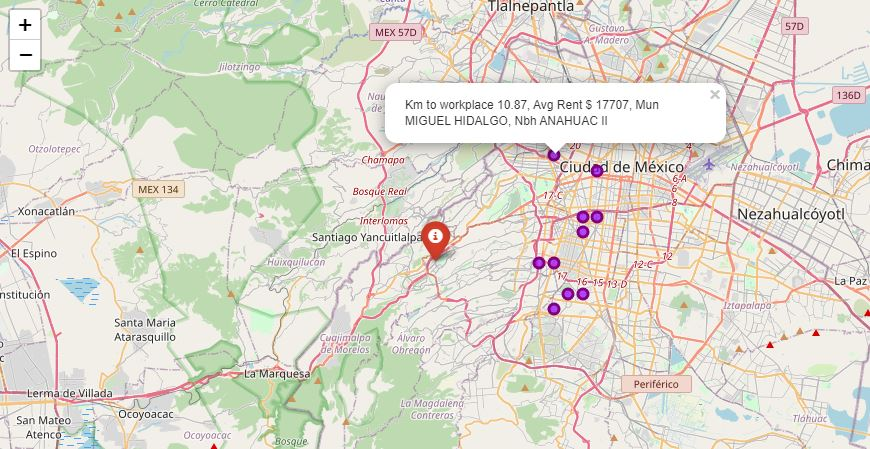

In [60]:
# Create a map of Mexico City to visualize the results

address = 'Mexico City'

geolocator = Nominatim(user_agent="mx_explorer")
cdmx_location = geolocator.geocode(address)
cdmx_latitude = location.latitude
cdmx_longitude = location.longitude
print('The geograpical coordinate of Mexico City are {}, {}.'.format(cdmx_latitude, cdmx_longitude))

The geograpical coordinate of Mexico City are 19.37187335, -99.26118151812653.


In [61]:
# Get user's office latitude and longitude

x = df_office['Latitude']
of_lat = x.values[0]
y = df_office['Longitude']
of_lon = y.values[0]
print(of_lat, ", ", of_lon)

19.37187335 ,  -99.26118151812653


In [158]:
# create map of Mexico City using latitude and longitude values

map_cdmx = folium.Map(location=[cdmx_latitude, cdmx_longitude], zoom_start=11)
 
# Get user's office latitude and longitude
    
folium.Marker(location=[of_lat, of_lon], popup='Office', icon=folium.Icon(color='red', icon='info-sign')).add_to(map_cdmx)

# add markers to map
for lat, lng, borough, neighborhood, average_rent, distance in zip(df_Top10['Latitude'], df_Top10['Longitude'], df_Top10['Municipality'], df_Top10['Neighborhood'], df_Top10['Rent'], df_Top10['Distance']):
    label = 'Km to workplace {}, Avg Rent $ {}, Mun {}, Nbh {}'.format(distance, average_rent, borough, neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='Purple',
        fill=True,
        fill_color='#9900FF',
        fill_opacity=0.7,
        parse_html=False).add_to(map_cdmx) 
    
map_cdmx

Last but not least, a second map is created to show the user in a map exactly what and where are the venues that match with the categories preferred by the user, and venues that also belong tho the top 10 neighborhoods identified.

![Venues in Neighborhoods top 10 map 2.JPG](attachment:Venues in Neighborhoods top 10 map 2.JPG)
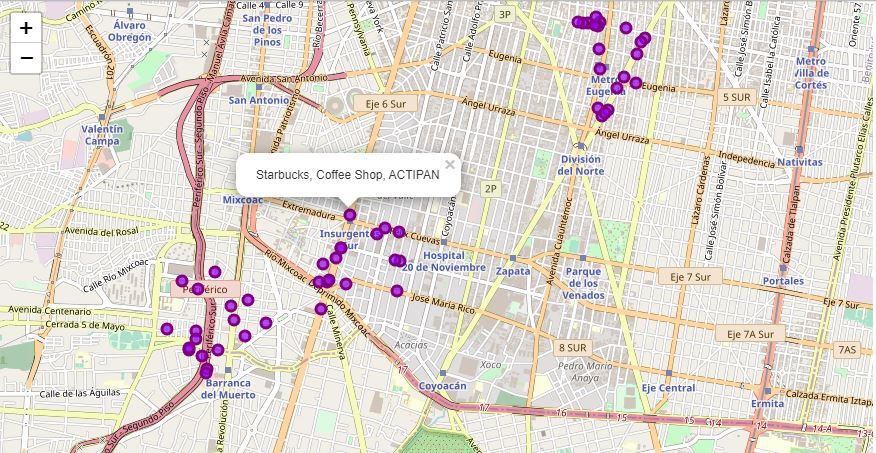

In [159]:
# New dataframe to get venues list of top neighborhoods + filter by venue categories

venue_categories_user = df_user['Venue Category'].tolist()

venues_cat_top = venues_top[venues_top['Venue Category'].isin(venue_categories_user)]
# venues_top10 = df_Top10.join(cdmx_merged.set_index('Neighborhood'), on='Neighborhood')

venues_cat_top.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
13,ACTIPAN,19.369882,-99.178167,Habanero Tienda de Chilaquiles,19.368549,-99.179139,Mexican Restaurant
26,ACTIPAN,19.369882,-99.178167,Starbucks,19.370656,-99.180018,Coffee Shop
27,ACTIPAN,19.369882,-99.178167,Glory Bee Pasticceria,19.370213,-99.181118,Coffee Shop
35,ACTIPAN,19.369882,-99.178167,Sports World,19.368758,-99.180809,Gym / Fitness Center
39,ACTIPAN,19.369882,-99.178167,Starbucks,19.371452,-99.179588,Coffee Shop


In [160]:
# create map of Mexico City using latitude and longitude values

venue_cat_map = folium.Map(location=[cdmx_latitude, cdmx_longitude], zoom_start=11)
    
# add markers to map

for lat, lng, neighborhood, category, venue in zip(venues_cat_top['Venue Latitude'], venues_cat_top['Venue Longitude'], venues_cat_top['Neighborhood'], venues_cat_top['Venue Category'], venues_cat_top['Venue']):
    label = '{}, {}, {}'.format(venue, category, neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='Purple',
        fill=True,
        fill_color='#9900FF',
        fill_opacity=0.7,
        parse_html=False).add_to(venue_cat_map) 
    
venue_cat_map